# Overview

In this notebook, we will train a baseline Random Forest model using tensorflow Decision Forests on the Spaceship Titanic.

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

os.environ['train']='/kaggle/input/spaceship-titanic/test.csv'
os.environ['test']='/kaggle/input/spaceship-titanic/train.csv'
os.environ['submission']='/kaggle/input/spaceship-titanic/sample_submission.csv'

# Loading the Data

In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f'% x)

train=pd.read_csv(os.getenv('train'))
test=pd.read_csv(os.getenv('test'))
df=pd.concat([train, test], ignore_index=True).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


# Basic Exploration of the Dataset

In [3]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000,12707.000,12681.000,12664.000,12686.000,12702.000
mean,28.772,222.898,451.962,174.906,308.477,306.789
std,14.387,647.597,1584.371,590.559,1130.280,1180.097
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,19.000,0.000,0.000,0.000,0.000,0.000
50%,27.000,0.000,0.000,0.000,0.000,0.000
75%,38.000,49.000,77.000,29.000,57.000,42.000
max,79.000,14327.000,29813.000,23492.000,22408.000,24133.000


In [4]:
def check_df(df):
    print("############# Shape #############")
    print(df.shape)
    print("############# Types #############")
    print(df.dtypes)
    print("############# Head #############")
    print(df.head(3))
    print("############# Tail #############")
    print(df.tail(3))
    print("############# NA #############")
    print(df.isnull().sum())
    print("############# Quantiles #############")
    numeric_columns=df.select_dtypes(include=['number']).columns
    # return values at the given quantile over requested axis
    print(df[numeric_columns].quantile([0,0.05, 0.50,0.95,0.99],1).T)

check_df(df)

############# Shape #############
(12970, 14)
############# Types #############
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
dtype: object
############# Head #############
  PassengerId HomePlanet CryoSleep  Cabin  Destination    Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e 27.000  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e 19.000  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e 31.000  False   

   RoomService  FoodCourt  ShoppingMall      Spa  VRDeck             Name  \
0        0.000      0.000         0.000    0.000   0.000  Nelly Carsoning   
1        0.000      9.000         0.000 2823.000   0.000   Lerome Peckers   
2        0.000   

# Visualization Dataset

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

_, _, num_cols=grab_col_names(df)

Observations: 12970
Variables: 14
cat_cols: 5
num_cols: 6
cat_but_car: 3
num_but_cat: 0


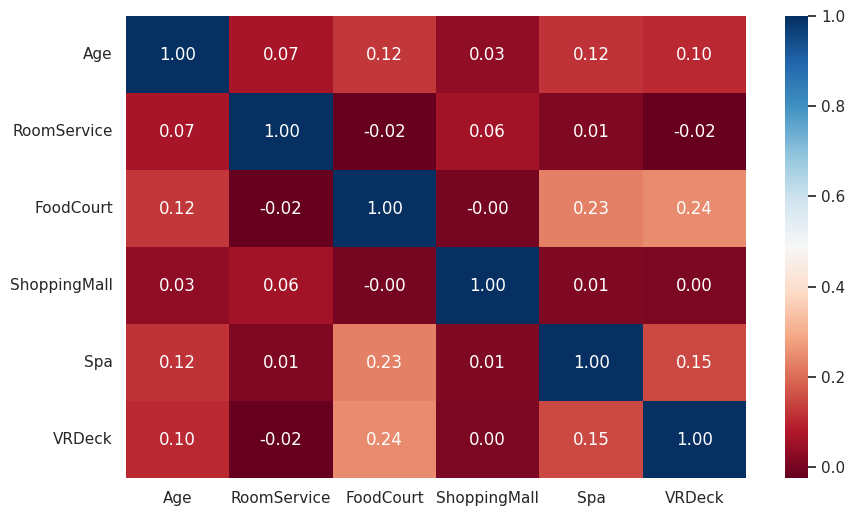

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr=df[num_cols].corr()
sns.set(rc={'figure.figsize': (10,6)})
sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f")
plt.show()

## Bar Char for Column: Transported

<Axes: xlabel='Transported'>

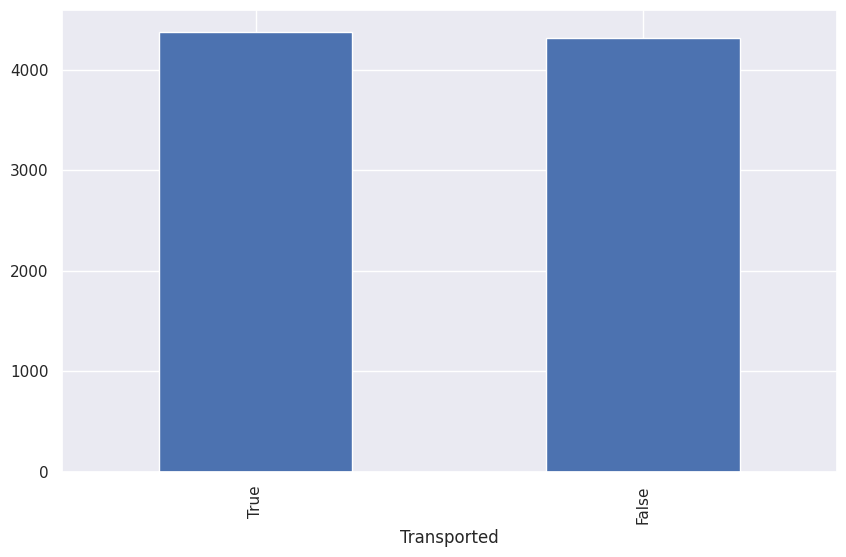

In [7]:
plot_df=df.Transported.value_counts()
plot_df.plot(kind="bar")

## Numerical Data Distribution

<Axes: xlabel='VRDeck', ylabel='Count'>

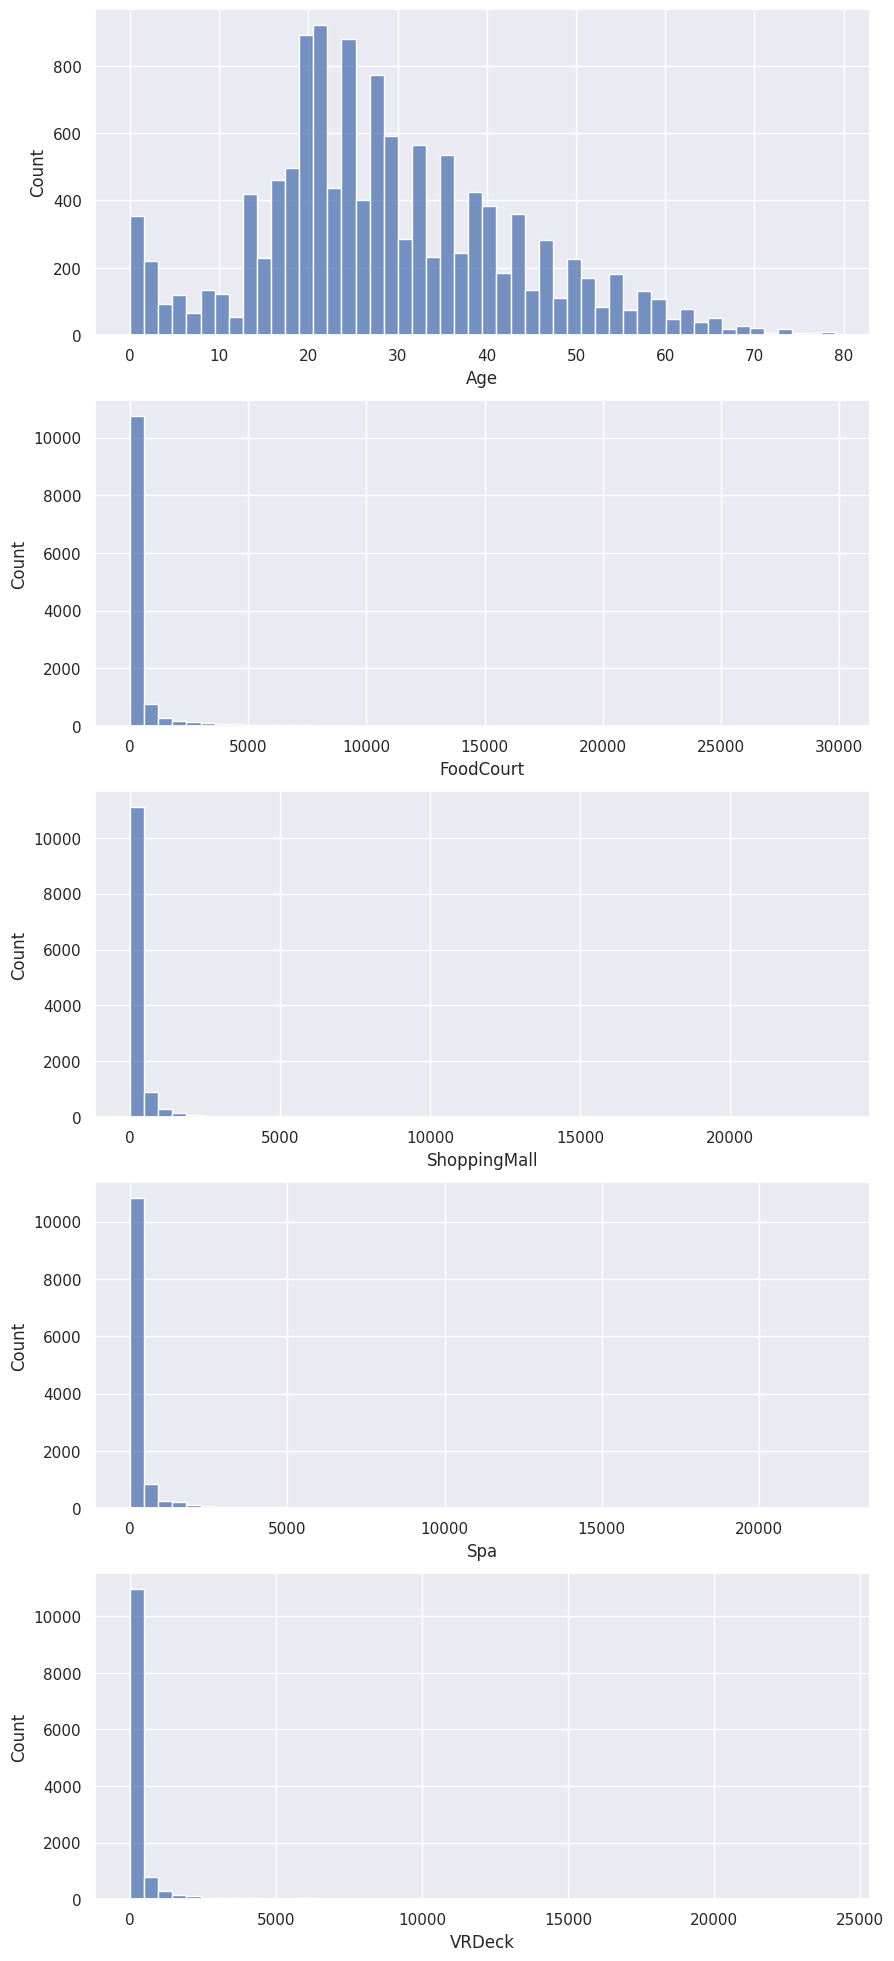

In [8]:
fig,ax=plt.subplots(5,1, figsize=(10,10))
plt.subplots_adjust(top=2)

sns.histplot(df['Age'], color='b', bins=50, ax=ax[0])
sns.histplot(df['FoodCourt'], color='b', bins=50, ax=ax[1])
sns.histplot(df['ShoppingMall'], color='b', bins=50, ax=ax[2])
sns.histplot(df['Spa'], color='b', bins=50, ax=ax[3])
sns.histplot(df['VRDeck'], color='b', bins=50, ax=ax[4])

# Example for Decision Forests

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks. Roughly, the code will look as follows:

```python
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset=pd.read_csv("dataset.csv")
tf_dataset=tfdf.keras.od_dataframe_to_tf_dataset(dataset, label="my_label")

model=tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

# Prepare the Dataset

We will drop both `PassengerId` and `Name` columns as they are not necessary for model training. And we also check for the missing values using the internal function of pandas.

In [9]:
df=df.drop(['PassengerId', 'Name'], axis=1)
df.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Earth,True,G/3/S,TRAPPIST-1e,27.000,False,0.000,0.000,0.000,0.000,0.000,NaN
1,Earth,False,F/4/S,TRAPPIST-1e,19.000,False,0.000,9.000,0.000,2823.000,0.000,NaN
2,Europa,True,C/0/S,55 Cancri e,31.000,False,0.000,0.000,0.000,0.000,0.000,NaN
3,Europa,False,C/1/S,TRAPPIST-1e,38.000,False,0.000,6652.000,0.000,181.000,585.000,NaN
4,Earth,False,F/5/S,TRAPPIST-1e,20.000,False,10.000,0.000,635.000,0.000,0.000,NaN


In [10]:
df.isnull().sum().sort_values(ascending=False)

Transported     4277
CryoSleep        310
ShoppingMall     306
Cabin            299
VIP              296
FoodCourt        289
HomePlanet       288
Spa              284
Destination      274
Age              270
VRDeck           268
RoomService      263
dtype: int64